In [3]:
#### Import Packages ####
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import HuberRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import resample
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import probplot
import itertools

In [4]:
#### Define functions to be used in analysis ####

# Function to create correlation plot
def CorrelationPlot(df):
    corr = df.corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
    plt.show()
    # return corr
    # return corr.style.background_gradient(cmap='coolwarm')

# Function to run regression on every possible subset of regressors and get model stats
def EverySubsetRegression(X_fun, y_fun):
    results = []
    predictors = X.columns

    # Iterate through each possible regression and add to results
    for k in range(1, len(predictors) + 1):
        for subset in itertools.combinations(predictors, k):
            X_subset = X[list(subset)]
            X_subset = sm.add_constant(X_subset)
            model = sm.OLS(y, X_subset).fit()
            
            # Append to results the info we want
            results.append({
                'Subset': subset,
                'Summary': model.summary(),
                'AIC': model.aic,
                'Adjusted R2': model.rsquared_adj,
                'Coefficients': model.params.to_dict()
            })
    return pd.DataFrame(results)

# Function to get all models with Adjusted R2 above defined value
def BestSubsets(df, cutoff):
    return df[df['Adjusted R2'] > cutoff]

# Function to create a Residuals vs. Predited plot
def BasicResidualPlot(test, predictions, title):
    res = test - predictions
    plt.scatter(predictions, res)
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title(f"{title} - Residual Plot")
    plt.axhline(y=0, color='r', linestyle='--')
    plt.show()

# Function for a normal probability plot
def NormalProbabilityPlot(test, predictions, title):
    res = test - predictions
    probplot(res, dist="norm", plot=plt)
    plt.title(f"{title} - Normal Probability Plot of Residuals")
    plt.show()


In [ ]:
#### Data Prep ####

# Load Data
df = pd.read_csv('mta_data.csv', sep='\t')
label_encoder = LabelEncoder()

# Run LabelEncoder() on categorical data
df['period'] = label_encoder.fit_transform(df['period'])
df['line'] = label_encoder.fit_transform(df['line'])
df['division'] = label_encoder.fit_transform(df['division'])

# Sort by month
df['month'] = pd.to_datetime(df['month'])
df = df.sort_values(by='month')
df = df.drop(columns=['month'])

# Create train and test data sets
X = df.drop(['customer journey time performance', 'over_five_mins', 'over_five_mins_perc'], axis = 1)
y = df['customer journey time performance']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


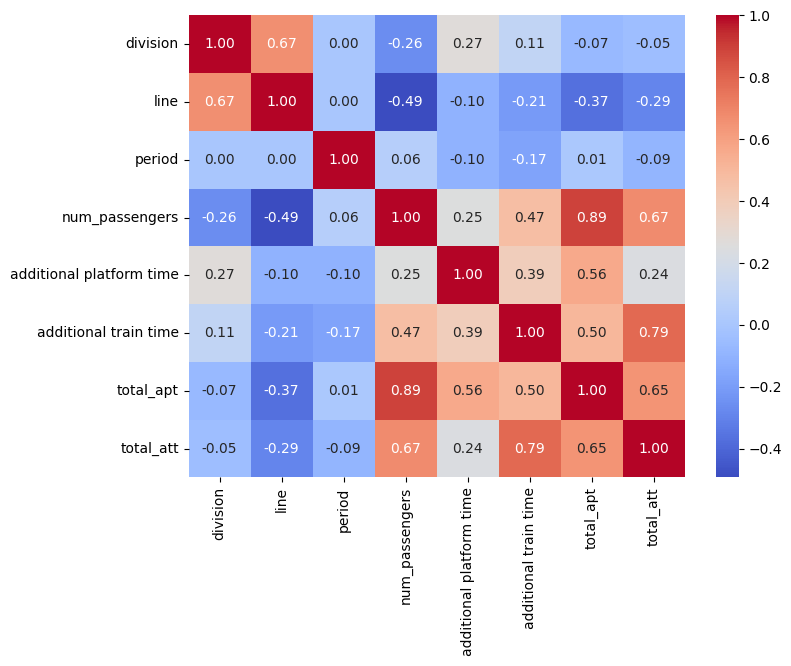

                    Feature        VIF
0                     const  35.111393
1                  division   2.421642
2                      line   2.624805
3                    period   1.077282
4            num_passengers  12.221484
5  additional platform time   3.545094
6     additional train time   3.289440
7                 total_apt  14.610201
8                 total_att   4.124333


In [7]:
#### Full Model Correlation Analysis ####

# Get correlation table for full model
CorrelationPlot(X)

# Compute VIF for each regressor
X_const = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data['Feature'] = X_const.columns
vif_data['VIF'] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

print(vif_data)

We see here that there is a fair amount of correlation amongst some of our regressors. Our main concern here is the impact of multicollinearity. The source of this is probably two-fold, (1) the data doesn't come from a designed experiment with correlation in mind, it's just general data about MTA train performance. This might be partially rectified with appropriate feature engineering. (2) The inclusion of all regressors. We'll address this later with different regression techinques (subset selection, Ridge regression, etc.) that hope to dampen the effects on our model performances.

We also look at the Variance Inflation Factors (VIFs) and notice two regressors in particular, num_passengers and total_apt, have high values. This suggests a strong effect from the dependencies among our regressors on the variances of each of these two features.

Another concern that we need to look our for is the effects of correlation amongst the observations themselves. Given that this data is on train performance, and multiple trains are recorded each day for the same line, there is possibility for correlation between our observations. For example, delays experienced by one train can impact performance of some/all trains later in that day, violating the assumption of independent observations.

One place we may see this is in the confidence intervals for our coefficients. We know that our 95% confidence intervals can be written as, $\hat{\beta_j}-t_{\alpha/2,n/p} \sqrt{\hat{\sigma^2}C_{jj}} \leq \beta_j \leq \hat{\beta_j}+t_{\alpha/2,n/p} \sqrt{\hat{\sigma^2}C_{jj}}$, where $C = (X'X)^{-1}$. We know that correlated observations will lead to lower values along the diagonal of $C$, and thus inflated values of $t_0$. Further, this leads to narrowed confidence intervals for our regression coefficients, something we will keep an eye on as we move forward.

In [8]:
#### Build Full Regression Model ####

full_model = sm.OLS(y, sm.add_constant(X)).fit()
print(full_model.summary())

# Note: Statsmodels is used first because of the nice summary output
# sklearn's LinearRegression() is used later for actual analysis
# This is redundent code, only used for output in the notebook. Production code would probably only use sklearn

                                    OLS Regression Results                                   
Dep. Variable:     customer journey time performance   R-squared:                       0.806
Model:                                           OLS   Adj. R-squared:                  0.806
Method:                                Least Squares   F-statistic:                     1482.
Date:                               Thu, 15 May 2025   Prob (F-statistic):               0.00
Time:                                       09:24:36   Log-Likelihood:                 6335.2
No. Observations:                               2856   AIC:                        -1.265e+04
Df Residuals:                                   2847   BIC:                        -1.260e+04
Df Model:                                          8                                         
Covariance Type:                           nonrobust                                         
                               coef    std err          t   

Looking at the summary of our full model we see initially that the two features with the highest VIFs are not significant at the $alpha=.05$ level. This is expected given the multicollinearity in our model (and on those features in particular), leading to inflated p-values. We also notice very narrow 95% confidence intervals for all of our coefficients. Given that we don't have great subject-matter expertise on MTA performance, it is difficult for us to determine if these bands are acceptable or suspicious.

For general model fit we see an ok model fit, as indicated by and Adjusted R2 of 0.806, and a negative AIC value. However, we also know (on top of multicollinearity) that the model may be misspecified, and that additional features increases our R2. We'll compare them to our other models later.

Finally, based on our F-statistic, our model may have good predicitve power.

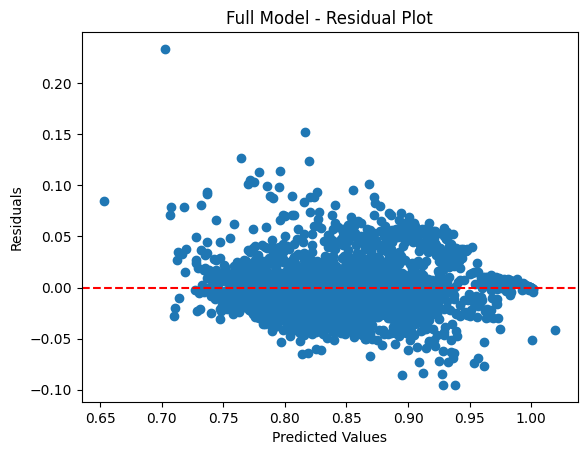

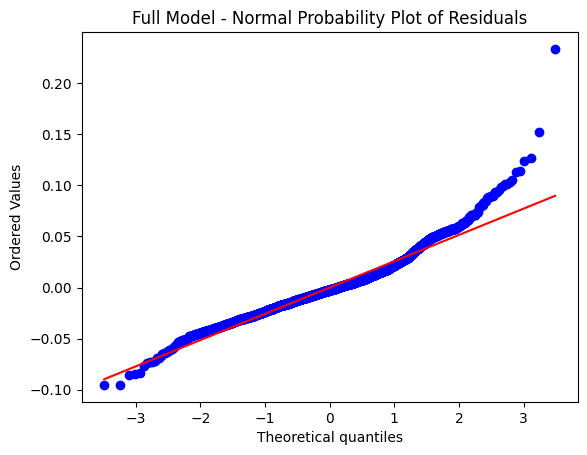

In [9]:
#### Full Model ####

# Build Full Model using sklearn's LinearRegression() (see note above)
full_model_sk = LinearRegression()
full_model_sk.fit(X, y)

# Get residual analysis plots for the full model
sk_residuals = full_model_sk.predict(X)
BasicResidualPlot(y, sk_residuals, 'Full Model')
NormalProbabilityPlot(y, sk_residuals, 'Full Model')

We see here that while our residuals generally have constant variance, there are clear outliers that could heavily impact model performance. Given the shape of the Q-Q chart it appears that our residuals are positively-skewed. In some cases we could check for the outliers in our data and delete them from the data, but given our lack of adequate subject-matter knowledge, that is not an option here. Instead, we will attempt two shrinkage methods, Ridge and LASSO regressions, and a robust model that uses Hubert's t function as our robust criterion function.

NOTE: Both variance-stabilizing transformations and transformations to linearlize our model were attempted when building this analysis. However, nothing was effective enough to include here, so the code was ommitted. I'm sure there's a solution there, but more time and subject-matter knowledge would be helpful.

Another option not explored in this analysis are generalized linear models, in particular beta regressions. Beause our response variable is a proportion and lies on the interval $[0,1]$, we could assume it follows a beta distribution, and create a generalized linear model with an appropriate link function (maybe the logit link).

     Feature   Coefficient
0  Intercept  1.742039e-12
1         x1  1.336008e-12
2         x2  2.776919e-11
3         x3  8.201142e-13
4         x4  3.103704e-07
5         x5  1.632023e-12
6         x6 -3.159048e-14
7         x7  1.116801e-08
8         x8 -1.196072e-07
R²: 0.8064
Adjusted R²: 0.8059
AIC: -20759.3998


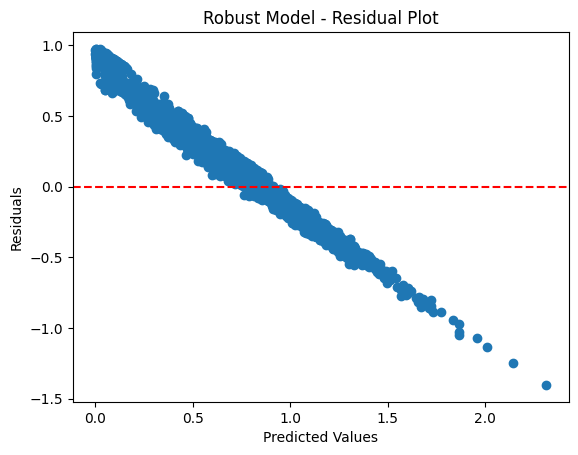

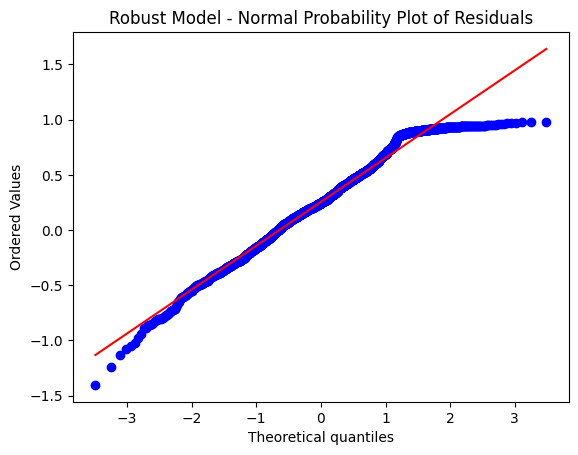

In [18]:
#### Try Huber Regressor to fix non-normal residual violation ####
### The hope is that this is more robust to our outliers ###

huber_model = HuberRegressor()
huber_model.fit(X, y)

# Create summary dataframe
huber_df = pd.DataFrame({
    "Feature": ["Intercept"] + [f"x{i}" for i in range(1, X.shape[1] + 1)],
    "Coefficient": np.append(huber_model.intercept_, huber_model.coef_)
})

print(huber_df)

r2 = 1 - (np.sum((y - sk_residuals)**2) / np.sum((y - np.mean(y))**2))

# Calculate Adjusted R²**
n = len(y)  # Number of observations
p = X.shape[1]  # Number of predictors
adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))

# Calculate AIC
mse = mean_squared_error(y, sk_residuals)
log_likelihood = -0.5 * n * np.log(mse)
aic = 2 * p - 2 * log_likelihood

print(f"R²: {r2:.4f}")
print(f"Adjusted R²: {adjusted_r2:.4f}")
print(f"AIC: {aic:.4f}")

# Get residual analysis plots
huber_residuals = huber_model.predict(X)
BasicResidualPlot(y, huber_residuals, 'Robust Model')
NormalProbabilityPlot(y, huber_residuals, 'Robust Model')

Given that our data appears to have outliers and a long-tailed error distribution, we are wary of using methods that rely on squared-error loss, given their tendency to place emphasis on observations with large absolute residuals $|y_i-f(x_i)|$. For that reason we look at models which use more robust criteria, like absolute loss. Here, we choose to use the Huber loss criterion used for M-regression,

$$
L(y,f(x)) =
\left\{
\begin{array}{ll}
      [y-f(x)]^2 & for |y-f(x)| \leq \delta \\
      2\delta |y-f(x)| - \delta^2 & otherwise. \\
\end{array}
\right\}
$$

Here the first thing we notice is the negative slope in our plot of predicted values vs. residuals. Given that the Huber loss criterion downweights extreme residuals, which our data has, we can guess that decreases as the model adjusts. This phenomenon is also seen at the end of the X space in our Q-Q plot. More analysis is needed here, but we may be able to correct these with further transformations or the selection of other robust criterion.

                                    OLS Regression Results                                   
Dep. Variable:     customer journey time performance   R-squared:                       0.806
Model:                                           OLS   Adj. R-squared:                  0.806
Method:                                Least Squares   F-statistic:                     1695.
Date:                               Wed, 14 May 2025   Prob (F-statistic):               0.00
Time:                                       15:32:19   Log-Likelihood:                 6335.1
No. Observations:                               2856   AIC:                        -1.265e+04
Df Residuals:                                   2848   BIC:                        -1.261e+04
Df Model:                                          7                                         
Covariance Type:                           nonrobust                                         
                               coef    std err          t   

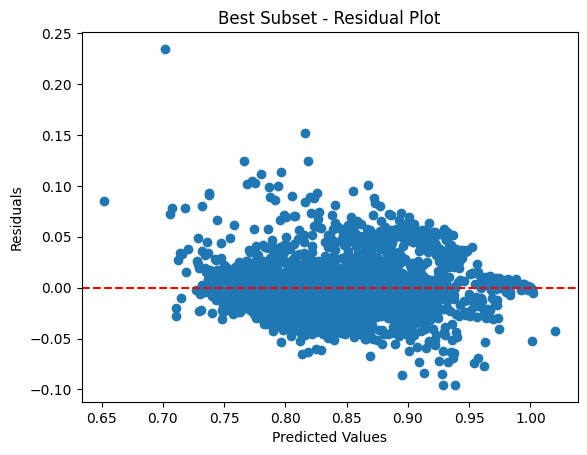

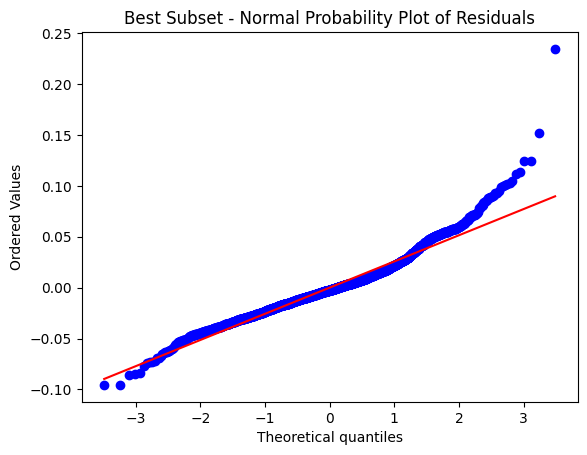

                    Feature        VIF
0                     const  16.635624
1                  division   2.420642
2                      line   2.380281
3                    period   1.069839
4  additional platform time   2.130814
5     additional train time   3.267649
6                 total_apt   2.891691
7                 total_att   4.092115


In [58]:
#### Best Subset Regression ####

# Run all possible subsets and select models with an Adjusted R² greater than 80%
# Isolate model with highest adjusted R² in possible_models variable
results_df = EverySubsetRegression(X, y)
results_df = results_df.sort_values(by='Adjusted R2', ascending=False)
possible_models = BestSubsets(results_df, cutoff = .8)

# Summary of best model
print(possible_models['Summary'].iloc[0])

# Isolate regressors in best subset
subset = possible_models['Subset'].iloc[0]

# Build linear model with best subset
subset_model = LinearRegression()
subset_model.fit(sm.add_constant(X[list(subset)]), y)

# Get residual analysis plots
subset_residuals = subset_model.predict(sm.add_constant(X[list(subset)]))
BasicResidualPlot(y, subset_residuals, 'Best Subset')
NormalProbabilityPlot(y, subset_residuals, 'Best Subset')

# Calc new VIFs
subset_vif = pd.DataFrame()
subset_vif['Feature'] = sm.add_constant(X[list(subset)]).columns
subset_vif['VIF'] = [variance_inflation_factor(sm.add_constant(X[list(subset)]).values, i) for i in range(sm.add_constant(X[list(subset)]).shape[1])]

print(subset_vif)

We see that the best subset, as determined by Adjusted R2 value, was the full model minus num_passengers. Given it's VIF we saw earlier this makes sense. Generally, however, our model still suffers from the same issues. We still have correlation amongst our observations, multicollinearity is still present, and there are outliers violating our assumptions that the residuals are normally distributed.

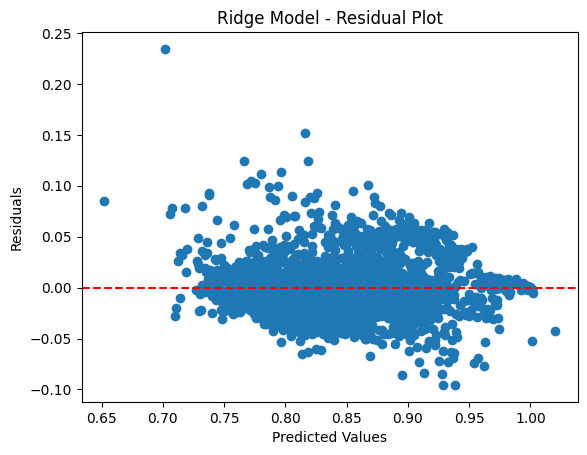

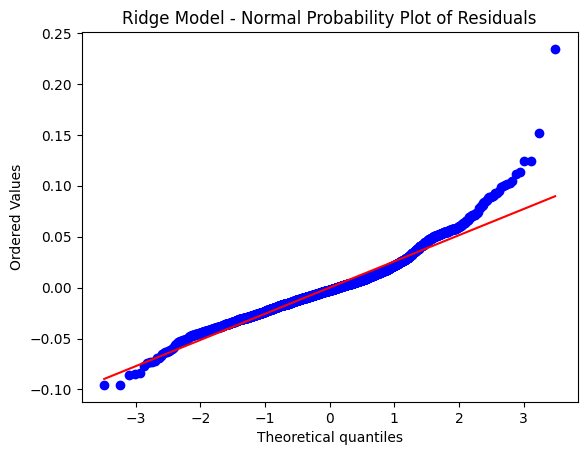

Ridge Coefficients: [-0.02700785  0.01862648  0.00639304 -0.03703894 -0.00535053  0.00172434
 -0.00432204]
Ridge AIC: 485521.12
Ridge R²: 0.8063971119997269
[-0.02700785  0.01862648  0.00639304 -0.03703894 -0.00535053  0.00172434
 -0.00432204]


In [59]:
#### Ridge Model ####

# Scale data before running ridge regression
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[list(subset)])

# Build ridge regression model
ridge_model = Ridge(alpha=1)
ridge_model.fit(X_scaled, y)

# Get residual analysis plots
ridge_residuals = ridge_model.predict(X_scaled)
BasicResidualPlot(y, ridge_residuals, 'Ridge Model')
NormalProbabilityPlot(y, ridge_residuals, 'Ridge Model')

# Calc R2 and AIC scores
ridge_r2 = r2_score(y, ridge_residuals)
ridge_sigma2 = np.var(y - ridge_residuals, ddof=1)

# Use normal distribution log-likelihood to calc AIC
ridge_ll = -len(ridge_residuals) / 2 * np.log(2 * np.pi * ridge_sigma2) - np.sum(y - ridge_residuals**2) / (2 * ridge_sigma2)
ridge_k = X_scaled.shape[1] + 1
ridge_aic = 2 * ridge_k - 2 * ridge_ll

print("Ridge Coefficients:", ridge_model.coef_)
print(f"Ridge AIC: {ridge_aic:.2f}")
print('Ridge R²: ' + str(ridge_r2))
print(ridge_model.coef_)

Our Ridge model seems to give us similar results to the best subset model, but with a noticeably higher AIC, suggesting worse model fit. Given that the model missecification issues are still present, this is unsurprising. The alpha parameter was left at 1 as higher levels further worsened model fit, suggesting other factors are impacting our model, and not just multicollinearity.

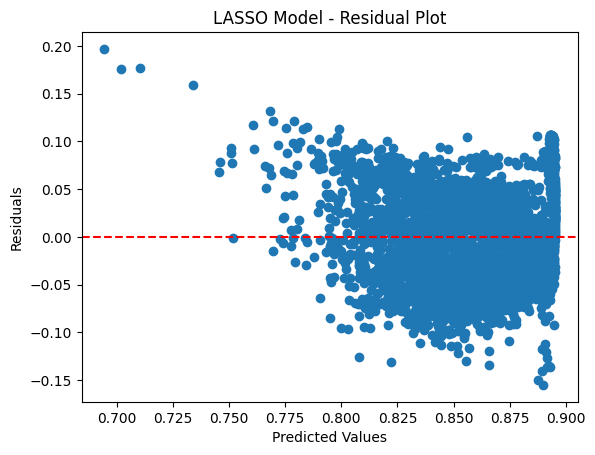

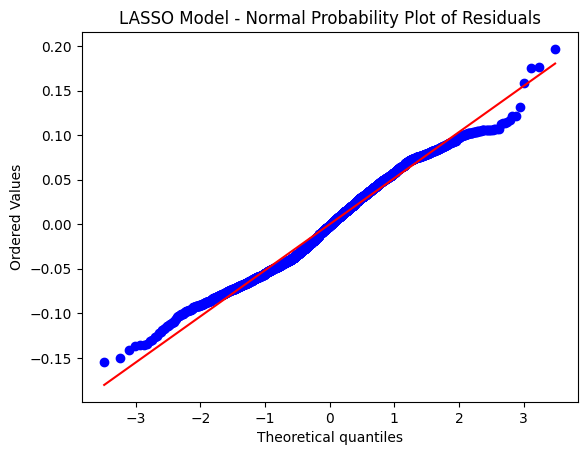

LASSO Coefficients: [-0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -1.31779674e-08 -2.76834837e-09]
LASSO AIC: 118878.69
LASSO R²: 0.24440761450213644
[-0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -1.31779674e-08 -2.76834837e-09]


In [60]:
#### LASSO Model ####

# Build LASSO regression model
lasso_model = Lasso(alpha = 1)
lasso_model.fit(X[list(subset)], y)

# Get residual analysis plots
lasso_residuals = lasso_model.predict(X[list(subset)])
BasicResidualPlot(y, lasso_residuals, 'LASSO Model')
NormalProbabilityPlot(y, lasso_residuals, 'LASSO Model')

# Calc R2 and AIC scores
lasso_r2 = r2_score(y, lasso_residuals)
lasso_sigma2 = np.var(y - lasso_residuals, ddof=1)

# Use normal distribution log-likelihood to calc AIC
lasso_ll = -len(lasso_residuals) / 2 * np.log(2 * np.pi * lasso_sigma2) - np.sum(y - lasso_residuals**2) / (2 * lasso_sigma2)
lasso_k = X[list(subset)].shape[1] + 1
lasso_aic = 2 * lasso_k - 2 * lasso_ll

print("LASSO Coefficients:", lasso_model.coef_)
print(f"LASSO AIC: {lasso_aic:.2f}")
print('LASSO R²: ' + str(lasso_r2))
print(lasso_model.coef_)

At first glance, we notice that the LASSO regression has shrunken several of our coefficients to zero. This is expected given that, unlike Ridge regression, the LASSO has a penalty on the $L_1$ norm, as seen in the LASSO problem,

$$\hat{\beta}^{lasso} = \underset{\beta}{\operatorname{\argmin}} \Bigl\{\frac{1}{2}\sum\limits_{i=1}^{N} (y_i-\beta _0 - \sum\limits_{j=1}^{p} x_{ij} \beta_j)^2 + \lambda \sum\limits_{j=1}^{p} |\beta_j| \Bigr\}$$

, and the classic graphical depiction of the error and constraint functions, where the LASSO is represented as a diamond.

In our situation, the LASSO model seems to have generally rectified the issuse of non-normally distributed residuals, but at great cost to our model fit and assumption of constanct residual variance. Given the LASSO's nature for sparsity, some valuable coefficients may have been shrunken to zero here, given the high level of correlation amongst our regressors.

In [61]:
#### Calc CV Score and Bootstrap Estimate for Subset and Robust (Huber) models ####

# Calculate Cross-Validation Score and Bootstrap .632 Estimate
def CVandBootstrap(model, X, y):

    # Calc CV Score        
    cv = np.mean(cross_val_score(model, X, y, cv=10, scoring='neg_mean_squared_error'))

    # Calc bootstrap estimate
    boot_scores = []
    for _ in range(100):
        X, y = resample(X, y)
        model.fit(X, y)
        boot_scores.append(mean_squared_error(y, model.predict(X)))
    boot632 = np.mean(boot_scores)

    results = pd.DataFrame({'cv_score': cv, 'bootstrap_estimate': boot632}, index = [0])

    return results

# Get CV score and bootsrap estimate for Best Subset Model
subset_scores = CVandBootstrap(model = subset_model, X = X[list(subset)], y = y)
print('Best Subset Scores:')
print(subset_scores)

# Get CV score and bootsrap estimate for Robust (Huber) Model
huber_scores = CVandBootstrap(model = huber_model, X = X, y = y)
print('Robust Model Scores:')
print(huber_scores)

Best Subset Scores:
   cv_score  bootstrap_estimate
0 -0.000724            0.000541
Robust Model Scores:
   cv_score  bootstrap_estimate
0 -0.230162            0.164691


Looking at our two "best" models, the best subset model and the robust model, we run basic diagnostics to check overall performance. Looking at both the Cross-Validation score and Bootstrap .632 estimate we see that, generally the best subset model outperforms our robust model. Given more time, it could be worthwhile to also look at the PRESS residuals and PRESS Statistic of each model to get a better understanding of the impact of outliers and predictive performnace, respectively.

We can conclude that neither model explains our model too well, and there are a few specification issues that need to be rectified. Extreme outliers violate the assumption of normally distributed residuals, correlation amongst both our regressors and observations impact model fit, coefficient estimation, and confidence interval construction, and there is implicit measurement error in our regressors (given that some of the our values for train arrival and departure times are calculated by hand by platform operators). Some possible solutions to these could possibly be found in outlier deletion, generalized linear models (beta regressions in partiuclar), further use of bootstrapping, data transformations, and total least squares models. Each of these is outside the scope of this analysis, and would require more subject-matter knowledge, but could be useful in further exploration.